In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

from sklearn import cross_validation
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv('device_failure_trainnig.csv')
print (df.shape)
df.head()

(74696, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74696 entries, 0 to 74695
Data columns (total 12 columns):
date          74696 non-null object
device        74696 non-null object
failure       74696 non-null int64
attribute1    74696 non-null int64
attribute2    74696 non-null int64
attribute3    74696 non-null int64
attribute4    74696 non-null int64
attribute5    74696 non-null int64
attribute6    74696 non-null int64
attribute7    74696 non-null int64
attribute8    74696 non-null int64
attribute9    74696 non-null int64
dtypes: int64(10), object(2)
memory usage: 6.8+ MB


In [4]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [5]:
print (df['failure'].value_counts())

0    74643
1       53
Name: failure, dtype: int64


In [6]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['failure']==0]
df_minority = df[df['failure']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=74643,    # to match majority class
                                 random_state=345) # reproducible results

# Combine majority class with upsampled minority class
df= pd.concat([df_majority,df_minority_upsampled])
 
# Display new class counts
df['failure'].value_counts()

1    74643
0    74643
Name: failure, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

number=LabelEncoder()

import datetime as dt

df['date']=df['date'].map(dt.datetime.toordinal)

df['device']=number.fit_transform(df['device'].astype('str'))

In [8]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,735599,0,0,215630672,56,0,52,6,407438,0,0,7
1,735599,1,0,61370680,0,3,0,6,403174,0,0,0
2,735599,2,0,173295968,0,0,0,12,237394,0,0,0
3,735599,3,0,79694024,0,0,0,6,410186,0,0,0
4,735599,4,0,135970480,0,0,0,15,313173,0,0,3


In [9]:
%matplotlib inline


# calculate the correlation matrix
df_heat = df.corr()

import seaborn as sns
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

df_heat.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

In [10]:
from sklearn.cross_validation import train_test_split

df.shape
dataset=df.values
Y = df["failure"]
X = df.drop('failure', axis=1).astype(float)

#Splitting the dataset into train and validation sets
validation_size = 0.30
seed = 21
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [13]:
num_folds = 10
num_instances = len(X_train)
seed = 3

models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART Decision Tree', DecisionTreeClassifier()))
models.append(('Naive Bayes', GaussianNB()))

from xgboost import XGBClassifier
models.append(('XGBoost', XGBClassifier()))

from sklearn import neural_network
#models.append(('Neural Network (MLP)', neural_network.MLPClassifier()))

from sklearn import ensemble
models.append(('Random Forest', ensemble.RandomForestClassifier()))

#models.append(('SVM', SVC()))
# evaluate each model
results = []
names = []
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for name, model in models:
        kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        msg = "model = %s:\n mean = %f std = (%f)\n" % (name, cv_results.mean(), cv_results.std())
        print(msg)

model = Logistic Regression:
 mean = 0.718172 std = (0.010017)

model = Linear Discriminant Analysis:
 mean = 0.711120 std = (0.003445)

model = KNN:
 mean = 0.998431 std = (0.000467)

model = CART Decision Tree:
 mean = 0.999809 std = (0.000113)

model = Naive Bayes:
 mean = 0.552919 std = (0.004852)

model = XGBoost:
 mean = 0.983962 std = (0.004462)

model = Random Forest:
 mean = 0.999837 std = (0.000096)



In [14]:
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
cv_results = cross_validation.cross_val_score(XGBClassifier(learning_rate=0.08, n_estimators=200, max_depth=10), X_train, Y_train, cv=kfold, scoring='accuracy')
msg = "model = XGBoost:\n mean = %f std = (%f)\n" % (cv_results.mean(), cv_results.std())
print(msg)

model = XGBoost:
 mean = 0.999742 std = (0.000160)



In [15]:
df_test = pd.read_csv('device_failure_test_data.csv')
print (df_test.shape)
df_test.head()

(24899, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-04-26,S1F118JP,0,234208528,0,0,0,7,213719,0,0,0
1,2015-04-26,S1F11C16,0,28072200,0,0,0,8,227476,0,0,0
2,2015-04-26,S1F11ETS,0,13986024,0,0,0,11,226985,0,0,0
3,2015-04-26,S1F11G2C,0,2048,0,0,0,16,336109,0,0,0
4,2015-04-26,S1F11K34,0,103853208,0,0,0,14,338808,0,0,0


In [17]:
df_test['date'] = pd.to_datetime(df_test['date'], dayfirst=True)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

number=LabelEncoder()

import datetime as dt

df_test['date']=df_test['date'].map(dt.datetime.toordinal)

df_test['device']=number.fit_transform(df_test['device'].astype('str'))

In [ ]:
X = df.drop('failure', axis=1).astype(float)
from sklearn.model_selection import cross_val_predict
proba = cross_val_predict(XGBClassifier(), X, cv=cv, method='predict_proba')

In [15]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: int64

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import cross_val_predict
from sklearn import ensemble
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

input = X
output = Y

rf = ensemble.RandomForestClassifier()
lr = linear_model.LogisticRegression()
gnb = GaussianNB()
svc = svm.SVC(C=100,gamma= 0.001000)
nn = neural_network.MLPClassifier()
xg=XGBClassifier(learning_rate=0.08, n_estimators=200, max_depth=10)

cv = 10
scores = cross_val_score(rf, input.as_matrix(),output, cv=cv,scoring = "roc_auc")
print ("RF",scores.mean(),scores.std())
scores = cross_val_score(lr, input.as_matrix(),output , cv=cv,scoring = "roc_auc")
print ("LR",scores.mean(),scores.std())
scores = cross_val_score(gnb, input.as_matrix(),output , cv=cv,scoring = "roc_auc")
print ("GNB",scores.mean(),scores.std())
#scores = cross_val_score(svc, input.as_matrix(),output.failure , cv=cv,scoring = "roc_auc")
#print ("SVC",scores.mean(),scores.std())
scores = cross_val_score(nn, input.as_matrix(),output , cv=cv,scoring = "roc_auc")
print ("NN",scores.mean(),scores.std())
scores = cross_val_score(xg, input.as_matrix(),output , cv=cv,scoring = "roc_auc")
print ("XGB",scores.mean(),scores.std())

predictedRF = cross_val_predict(rf, input.as_matrix(), output, cv=cv)
predictedLR = cross_val_predict(lr, input.as_matrix(), output, cv=cv)
predictedGNB = cross_val_predict(gnb, input.as_matrix(), output, cv=cv)
predictedSVC = cross_val_predict(svc, input.as_matrix(), output, cv=cv)
predictedNN = cross_val_predict(nn, input.as_matrix(), output, cv=cv)
predictedXGB = cross_val_predict(xg, input.as_matrix(), output, cv=cv)

print (len(predictedLR))
false_positive_rateRF, true_positive_rateRF, thresholdsRF = roc_curve(output.broken, predictedRF)

roc_aucRF = auc(false_positive_rateRF, true_positive_rateRF)

false_positive_rateLR, true_positive_rateLR, thresholdsLR = roc_curve(output.broken, predictedLR)
roc_aucLR = auc(false_positive_rateLR, true_positive_rateLR)

print (roc_aucRF)

RF 0.999946414816 6.56263474969e-05
LR 0.765627747702 0.0158407720084
GNB 0.675113421803 0.0158467069813


In [17]:
new_df=pd.concat([input,output],axis=1)

In [19]:
print (new_df.broken.value_counts())

0    603
1    397
Name: broken, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split

y=df['failure']
X=df.drop('failure', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0, random_state=42)

# create training and testing vars
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(149286, 11) (149286,)
(0, 11) (0,)


In [18]:
y_test = df_test['failure']
X_test = df_test.drop('failure', axis=1).astype(float)

In [19]:
import xgboost as xgb

from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print (xgb_model.score(X_train,y_train))

from sklearn.metrics import accuracy_score
pred_y_0 = xgb_model.predict(X_test)
print( accuracy_score(pred_y_0, y_test))


0.990977050762
0.984176071328


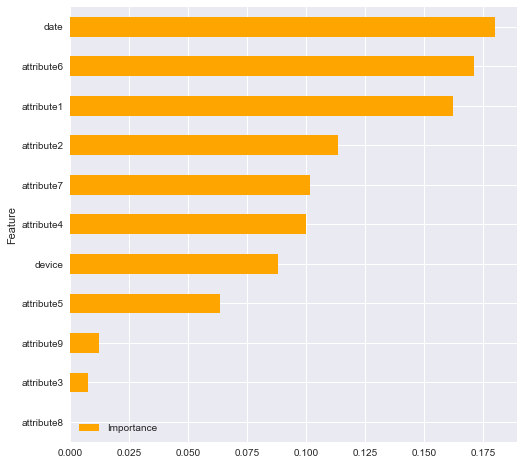

In [22]:
%matplotlib inline

importances=xgb_model.feature_importances_

importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(X_train.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')

In [21]:

probs=xgb_model.predict_proba(X_test)

print ("Failure probabilities:",probs)

Failure probabilities: [[ 0.99461281  0.00538717]
 [ 0.96299535  0.03700467]
 [ 0.97714847  0.02285153]
 ..., 
 [ 0.231915    0.768085  ]
 [ 0.61269033  0.38730964]
 [ 0.94441277  0.05558724]]


In [26]:
prob_df=pd.DataFrame(probs, columns=["probability_of_not_failure","probability_of_failure"])

In [27]:
final_df=pd.concat([df_test,prob_df],axis=1)


In [28]:
final_df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,probability_of_not_failure,probability_of_failure
0,735714,142,0,234208528,0,0,0,7,213719,0,0,0,0.994613,0.005387
1,735714,144,0,28072200,0,0,0,8,227476,0,0,0,0.962995,0.037005
2,735714,145,0,13986024,0,0,0,11,226985,0,0,0,0.977148,0.022852
3,735714,146,0,2048,0,0,0,16,336109,0,0,0,0.986893,0.013107
4,735714,147,0,103853208,0,0,0,14,338808,0,0,0,0.981386,0.018614


In [29]:
final_df.to_csv("Test results with probabilities.csv")